In [1]:
#pip install pyfasta seaborn pandas matplotlib_venn

In [2]:
from pyfasta import Fasta
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
import assembly_categories
import bgc_parse_and_extract

0 minia 0 cs.gc 18544 cs.gc.cv assemblies


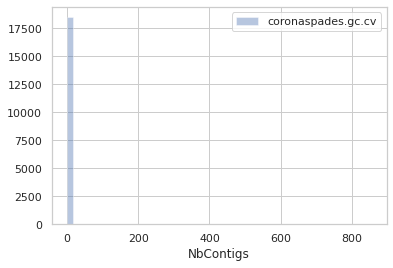

In [3]:
import glob
import os


assemblies = glob.glob("/home/rayan/serratus-assemblies/*.fa")
minia, coronaspades, coronaspades_gc, coronaspades_gc_cv = [], [], [], []
for assembly in assemblies:
    assembly = assembly
    if "coronaspades.checkv_filtered" in assembly:
        coronaspades += [assembly]
    elif "minia.checkv_filtered" in assembly:
        minia += [assembly]
    elif "coronaspades.gene_clusters.fa" in assembly:
        coronaspades_gc += [assembly]
    elif "coronaspades.gene_clusters.checkv_filtered.fa" in assembly:
        coronaspades_gc_cv += [assembly]

# focusing on gc_cv
minia, coronaspades_gc = [],[]

print(len(minia),"minia",len(coronaspades_gc),"cs.gc",len(coronaspades_gc_cv),"cs.gc.cv assemblies")

data_to_insert = []
for assemblies,assembler in [
                             #(minia,'miniak31.cv'),
                             #(coronaspades,'coronaspades.cv'),
                             #(coronaspades_gc,'coronaspades.gc')
                             (coronaspades_gc_cv,'coronaspades.gc.cv'),
                            ]:
    for assembly in assemblies:
        if os.stat(assembly).st_size == 0:
            nb_contigs = 0
            total_length = 0
        else:
            f = Fasta(assembly)
            nb_contigs = len(f.keys())
            total_length = sum([len(f[key]) for key in f.keys()])
            
        category = assembly_categories.get_category(total_length, nb_contigs)
        
        data_to_insert += [(assembly.replace('/home/rayan/serratus-assemblies/',''), 
                            assembler, nb_contigs, total_length, category)]
        
data = pd.DataFrame(data_to_insert, columns=['Assembly', 'Assembler', 'NbContigs', 'TotalLength', 'Category'])

sns.set(style="whitegrid")
#sns.distplot(data[data['Assembler'] == 'miniak31.cv']['NbContigs'], kde=False, rug=True, label="miniak31.cv");
#sns.distplot(data[data['Assembler'] == 'coronaspades.cv']['NbContigs'], kde=False, rug=True, label="coronaspades.cv");
#sns.distplot(data[data['Assembler'] == 'coronaspades.gc']['NbContigs'], kde=False, label="coronaspades.gc");
sns.distplot(data[data['Assembler'] == 'coronaspades.gc.cv']['NbContigs'], kde=False, label="coronaspades.gc.cv");
plt.legend()

data.to_csv('data.csv')



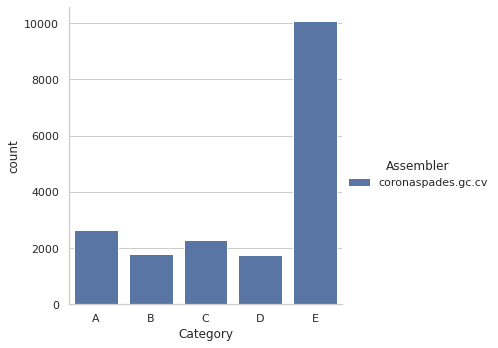

In [4]:
sns.catplot(x="Category", kind="count", order=('A','B','C','D','E'), data=data, hue='Assembler');

In [5]:
version = 3
gc_cv_catABC = set()
gc_cv_catABCD = set()
def produce_cat(category):
    global gc_cv_catABC,gc_cv_catABCD
    cat_gc_cv = list(map(lambda x: 's3://serratus-public/assemblies/contigs/' + x, 
             list(data[
                 (data['Assembler'] == 'coronaspades.gc.cv') 
                 & 
                 (data['Category'] == category) ]['Assembly'])))
    f = open("cat%s-v%d.txt" % (category,version),"w")
    print(len(cat_gc_cv),"cat%s saved"%category)
    for l in cat_gc_cv:
        f.write(l+"\n")
    f.close()
    f = open("cat%s-v%d.accessions.txt" % (category,version),"w")
    for l in cat_gc_cv:
        f.write(l.replace('s3://serratus-public/assemblies/contigs/','')
                .replace('.coronaspades.gene_clusters.checkv_filtered.fa','')
                +"\n")
    f.close()
    f = open("cat%s-v%d.fa" % (category,version),"w")
    for l in cat_gc_cv:
        filename = l.replace('s3://serratus-public/assemblies/contigs/','')
        g = Fasta("/home/rayan/serratus-assemblies/" + filename)
        for key in g.keys():
            contig = g[key]
            accession = filename.replace('.coronaspades.gene_clusters.checkv_filtered.fa','')
            if category != 'D':
                gc_cv_catABC.add(accession)
            gc_cv_catABCD.add(accession)
            contig_name = str(key)
            if contig_name.startswith('NODE'):
                contig_name = accession + ".coronaspades." + contig_name
            f.write(">%s\n" % (contig_name))
            f.write(str(contig) + "\n")
    f.close()
for category in ['A','B','C','D']:
    produce_cat(category)
print(len(gc_cv_catABC),"cat A+B+C")
print(len(gc_cv_catABCD),"cat A+B+C+D")

2643 catA saved
1773 catB saved
2289 catC saved
1760 catD saved
6705 cat A+B+C
8465 cat A+B+C+D


### Now, consider BGC 2+ CoV hits

In [6]:
from importlib import reload
from collections import defaultdict
reload(bgc_parse_and_extract)

bgc_2_plus_accs = set()
hist_hits = defaultdict(list)
for bgc_statistics in glob.glob("/home/rayan/serratus-assemblies/*.bgc_statistics.txt"):
    gc = bgc_statistics.replace('bgc_statistics.txt','gene_clusters.fa')
    accession, nb_cov_bgc, bgc_contigs_filename = bgc_parse_and_extract.process(bgc_statistics)
    if nb_cov_bgc is not None and nb_cov_bgc >= 2:
        bgc_2_plus_accs.add(accession)
    hist_hits[nb_cov_bgc] += [accession]
print(len(bgc_2_plus_accs),"BGC 2+ CoV")


cluster_8_candidate_1_domains_2 contig not found in /home/rayan/serratus-assemblies/SRR11954233.coronaspades.gene_clusters.fa
cluster_1_candidate_1_domains_14 contig not found in /home/rayan/serratus-assemblies/SRR11954146.coronaspades.gene_clusters.fa
cluster_3_candidate_1_domains_7 contig not found in /home/rayan/serratus-assemblies/SRR11954146.coronaspades.gene_clusters.fa
cluster_1_candidate_1_domains_42 contig not found in /home/rayan/serratus-assemblies/SRR1030193.coronaspades.gene_clusters.fa
cluster_1_candidate_1_domains_11 contig not found in /home/rayan/serratus-assemblies/SRR11549974.coronaspades.gene_clusters.fa
cluster_13_candidate_1_domains_2 contig not found in /home/rayan/serratus-assemblies/SRR11953885.coronaspades.gene_clusters.fa
cluster_1_candidate_1_domains_33 contig not found in /home/rayan/serratus-assemblies/SRR11953698.coronaspades.gene_clusters.fa
cluster_1_candidate_1_domains_14 contig not found in /home/rayan/serratus-assemblies/SRR11550007.coronaspades.gene

In [7]:
for nb_hits in sorted([x for x in hist_hits.keys() if x is not None]):
    print(nb_hits,":",len(hist_hits[nb_hits]))

0 : 13284
1 : 2925
2 : 1275
3 : 951
4 : 697
5 : 497
6 : 406
7 : 297
8 : 246
9 : 226
10 : 199
11 : 172
12 : 155
13 : 177
14 : 149
15 : 151
16 : 138
17 : 117
18 : 108
19 : 89
20 : 77
21 : 78
22 : 66
23 : 50
24 : 58
25 : 42
26 : 48
27 : 30
28 : 33
29 : 21
30 : 29
31 : 28
32 : 26
33 : 18
34 : 18
35 : 8
36 : 12
37 : 14
38 : 11
39 : 11
40 : 5
41 : 8
42 : 7
43 : 8
44 : 9
45 : 11
46 : 7
47 : 5
48 : 2
49 : 6
50 : 6
51 : 4
52 : 5
53 : 5
54 : 3
55 : 5
56 : 4
57 : 5
58 : 6
59 : 2
60 : 2
61 : 1
62 : 2
63 : 2
64 : 4
65 : 7
66 : 1
67 : 1
68 : 2
69 : 6
70 : 3
71 : 5
72 : 4
73 : 1
74 : 6
75 : 2
76 : 2
77 : 3
78 : 4
79 : 4
80 : 3
81 : 4
82 : 3
83 : 1
84 : 1
85 : 5
87 : 3
88 : 2
90 : 4
91 : 4
93 : 6
94 : 4
95 : 2
96 : 5
97 : 1
98 : 2
99 : 5
100 : 2
101 : 4
102 : 2
105 : 1
107 : 3
108 : 4
109 : 2
110 : 4
111 : 2
112 : 1
113 : 1
114 : 4
115 : 2
116 : 1
118 : 3
119 : 1
121 : 3
122 : 1
123 : 3
125 : 3
126 : 3
127 : 2
128 : 1
129 : 1
130 : 1
131 : 1
132 : 2
133 : 2
135 : 1
136 : 6
137 : 1
139 : 2
140 : 4
141 

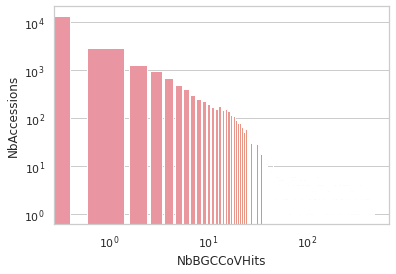

In [8]:
data = pd.DataFrame([(x,len(y)) for (x,y) in hist_hits.items() if x is not None], columns=['NbBGCCoVHits', 'NbAccessions'])
sns.set(style="whitegrid")
g = sns.barplot(x="NbBGCCoVHits", y="NbAccessions", data=data)
g.set_yscale("log")
g.set_xscale("log")

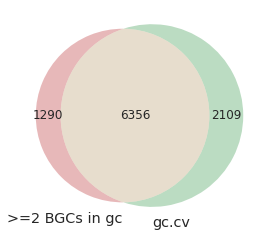

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 

# Second way
venn2([bgc_2_plus_accs, gc_cv_catABCD], set_labels = ('>=2 BGCs in gc', 'gc.cv'))
plt.show()
 